# K-nearest neighbor for classification

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import neighbors, datasets, preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
# Load data
dirpath_rawdata = "Data/Raw Data/Preliminary"
dirpath_transformed = "Data/Preprocessed Data/"

In [4]:
dict_transformed_data = dict()

for data in os.listdir(dirpath_transformed):

    data_name = data.replace(".csv", "")
    dict_transformed_data.setdefault(data_name, pd.read_csv(os.path.join(os.getcwd(), dirpath_transformed, data)))

print(dict_transformed_data.keys())
dict_transformed_data['transformed_cross']

dict_keys(['transformed_cross', 'transformed_jab', 'transformed_lft_nopunch', 'transformed_lh', 'transformed_lu', 'transformed_rght_nopunch', 'transformed_rh', 'transformed_ru'])


,X (m/s^2),Y (m/s^2),Z (m/s^2),X (rad/s),Y (rad/s),Z (rad/s),X (hPa),Punch Type
0,6.137,6.095,3.791,0.206,0.902,0.285,1012.885818,cross
1,14.568,28.642,10.195,2.934,5.756,2.912,1012.895355,cross
2,12.615,22.545,10.761,2.541,7.395,2.865,1012.904816,cross
3,13.644,21.431,8.318,2.365,6.340,2.121,1012.911606,cross
4,13.778,29.763,11.123,3.318,8.487,3.265,1012.919388,cross
...,...,...,...,...,...,...,...,...
297,10.143,13.389,6.017,0.790,3.033,2.237,1012.927442,cross
298,12.279,13.465,6.075,1.250,3.691,2.446,1012.927442,cross
299,7.412,12.693,4.174,0.863,3.172,2.020,1012.927442,cross
300,9.400,13.402,4.653,1.272,3.341,2.358,1012.927442,cross


In [5]:
# Remove outliers
def remove_outliers(df):

    # Remove the label from the original df because string is not used for statistics
    df_no_outliers = df.iloc[:,:-1].copy()
    df_label = df["Punch Type"].unique()

    accelerometer_feature = "(m/s^2)"

    for feature in df_no_outliers.columns:
        
        # Calculate Q1 (25th percentile) and Q3 (75th percentile) of each feature
        Q1 = df_no_outliers[feature].quantile(0.25)
        Q3 = df_no_outliers[feature].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define outlier criteria
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers, but treat Acceleration and other features differently (see report for details)
        if accelerometer_feature in feature:
            df_no_outliers = df_no_outliers[~((df_no_outliers[feature] < lower_bound))]
            
        else:
            df_no_outliers = df_no_outliers[~((df_no_outliers[feature] < lower_bound) | (df_no_outliers[feature] > upper_bound))]

    # Assign the label back
    df_no_outliers["Punch Type"] = df_label[0]

    return df_no_outliers

In [6]:
def make_violinplot_feature(df, cls, figsize = (10,10), savefig=False):

    df_copy = df.copy()
    
    if "X (hPa)" in df.columns:
        df_copy = df_copy.drop('X (hPa)', axis=1)

    plt.figure(figsize=figsize)    
    sns.violinplot(df_copy)
    plt.title(f"Violinplot of features in {cls}")

    if savefig:
        plt.savefig(f"Figures\\violin_{cls}.png")
        
    plt.show()

def make_violinplot_punchtype(feature, figsize = (10,10), savefig=False):
    df_joined = pd.concat([df for df in dict_transformed_data.values()],axis=0)

    plt.figure(figsize=figsize)
    df_melted = df_joined.melt(id_vars='Punch Type', value_vars=[feature], var_name='Feature', value_name='Value')
    
    plt.figure(figsize=figsize)
    sns.violinplot(data=df_melted, x='Feature', y='Value', hue='Punch Type', split=True)
    plt.title(f"Violinplot of {feature} across classes")
    
    if savefig:
        plt.savefig(f"violinplot_{feature}.png")
    
    plt.show()


<Figure size 1000x1000 with 0 Axes>

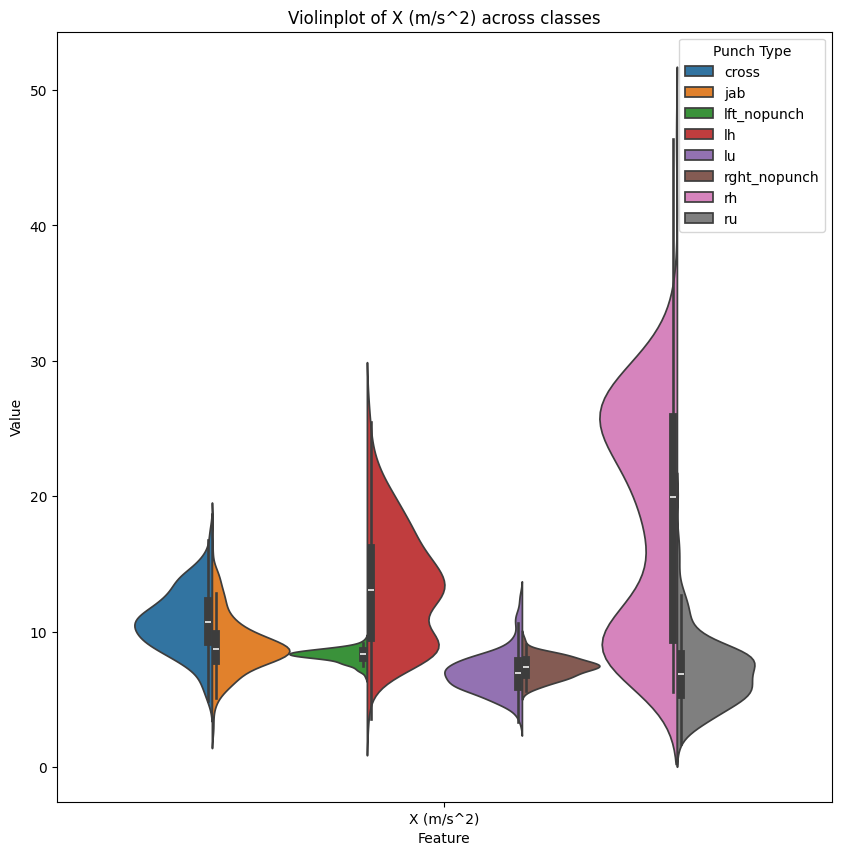

In [7]:
make_violinplot_punchtype("X (m/s^2)")

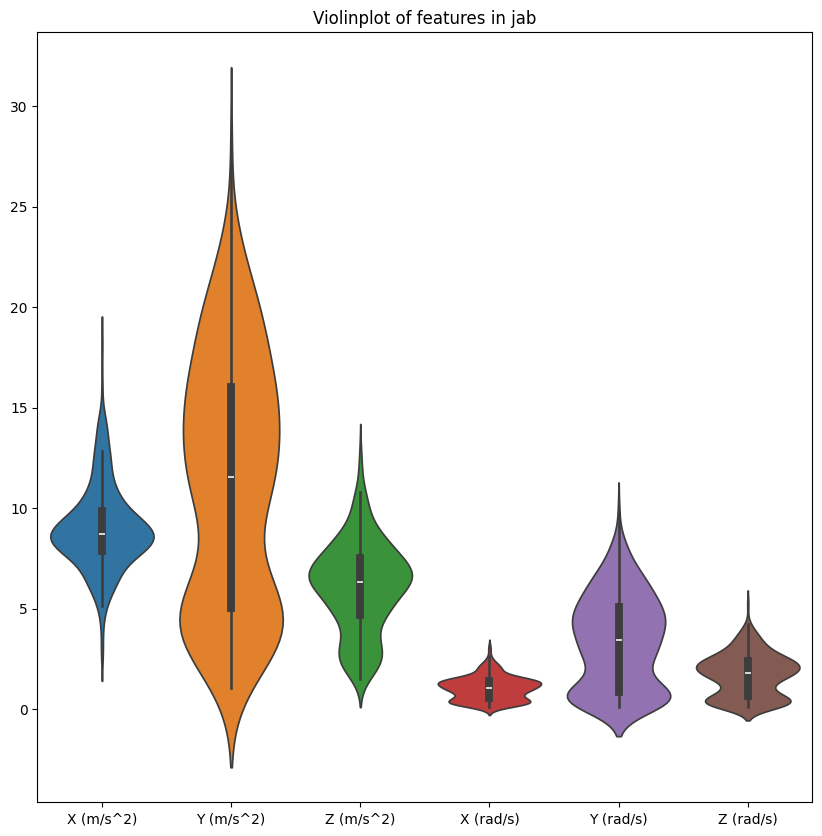

In [8]:
make_violinplot_feature(dict_transformed_data["transformed_jab"], 'jab', savefig=True)

In [9]:
for df in dict_transformed_data.keys():
    dict_transformed_data[df] = remove_outliers(dict_transformed_data[df])

In [10]:
# Standardize the data
scaler = MinMaxScaler()

for df in dict_transformed_data.keys():
    feature, label = dict_transformed_data[df].iloc[:,:-1], dict_transformed_data[df].iloc[:,-1]
    feature = scaler.fit_transform(feature)
    dict_transformed_data[df] = pd.concat([pd.DataFrame(feature), label], axis=1)
    dict_transformed_data[df] = dict_transformed_data[df].dropna()


In [11]:
for i in dict_transformed_data.values():
    print(i)

            0         1         2         3         4         5         6  \
0    0.102471  0.162994  0.297874  0.011652  0.093156  0.041496  0.000000   
2    0.706754  0.889853  0.753903  0.910112  0.852654  0.511783  0.320994   
3    0.776383  0.774397  0.713206  0.856846  0.847346  0.626793  0.630586   
6    0.200596  0.172567  0.336658  0.166875  0.139525  0.203893  0.524223   
9    0.668277  0.923219  0.703334  0.969205  0.795810  0.650102  0.468184   
..        ...       ...       ...       ...       ...       ...       ...   
286  0.424938  0.508697  0.522111  0.254682  0.390782  0.541496  0.518110   
287  0.596877  0.512299  0.527954  0.446109  0.482682  0.595031  0.518110   
288  0.205103  0.475710  0.336456  0.285060  0.410196  0.485912  0.518110   
289  0.365129  0.509313  0.384708  0.455264  0.433799  0.572490  0.518110   
290  0.511471  0.056259  0.237735  0.284644  0.204330  0.363730  0.518110   

    Punch Type  
0        cross  
2        cross  
3        cross  
6      

In [12]:
# Divide the data into train-test sets and merge all subdataframes into a whole one

x_train_whole = dict()
y_train_whole = dict()
x_test_whole = dict()
y_test_whole = dict()

for data in dict_transformed_data.keys():
    df_to_process = dict_transformed_data[data]
    data_name = data.replace("transformed_", "")
    x,y = df_to_process.iloc[:,:-1], df_to_process.iloc[:,-1]
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=50)
    
    x_train_whole.setdefault(data_name, x_train)
    x_test_whole.setdefault(data_name, x_test)
    y_train_whole.setdefault(data_name,y_train)
    y_test_whole.setdefault(data_name, y_test)

In [13]:
x_train_whole = pd.concat([df for df in x_train_whole.values()], axis=0)
y_train_whole = pd.concat([df for df in y_train_whole.values()], axis=0)

x_test_whole = pd.concat([df for df in x_test_whole.values()], axis=0)
y_test_whole = pd.concat([df for df in y_test_whole.values()], axis=0)

In [14]:
def shuffle_data(feature, label):
    
    df_unshuffled = pd.concat([feature, label], axis=1)
    df_shuffled = df_unshuffled.sample(frac=1.0, random_state=50)
    shuffled_feature, shuffled_label = df_shuffled.iloc[:,:-1], df_shuffled.iloc[:,-1]
    return shuffled_feature, shuffled_label

# Train test data that have been shuffled and preprocessed.
x_train_shuffled, y_train_shuffled = shuffle_data(x_train_whole, y_train_whole)
x_test_shuffled, y_test_shuffled = shuffle_data(x_test_whole, y_test_whole)

# Model training and classification report

In [15]:
k = 8
knn = KNeighborsClassifier(n_neighbors=k)

knn.fit(x_train_shuffled, y_train_shuffled)

y_pred = knn.predict(x_test_shuffled)

print("Confusion Matrix:")
print(confusion_matrix(y_test_shuffled, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_shuffled, y_pred))

Confusion Matrix:
[[36 16  1  5  2  0  9  1]
 [ 9 56  0  2  3  0  2  0]
 [ 3  2 12  2  1  0  0  1]
 [ 8 15  0 34  5  0  3  2]
 [ 4  8  0  8 34  0  3 12]
 [ 5  4  1  1  2  7  3  0]
 [12  7  0  4  3  0 40  0]
 [ 3  6  0  1 18  0  3 45]]

Classification Report:
              precision    recall  f1-score   support

       cross       0.45      0.51      0.48        70
         jab       0.49      0.78      0.60        72
 lft_nopunch       0.86      0.57      0.69        21
          lh       0.60      0.51      0.55        67
          lu       0.50      0.49      0.50        69
rght_nopunch       1.00      0.30      0.47        23
          rh       0.63      0.61      0.62        66
          ru       0.74      0.59      0.66        76

    accuracy                           0.57       464
   macro avg       0.66      0.55      0.57       464
weighted avg       0.60      0.57      0.57       464



In [16]:
# Compare with the dummy classifier

dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(x_train_shuffled, y_train_shuffled)

dummy_pred = dummy_clf.predict(x_test_shuffled)

print("Confusion Matrix:")
print(confusion_matrix(y_test_shuffled, dummy_pred))
print("\nClassification Report:")
print(classification_report(y_test_shuffled, dummy_pred))

Confusion Matrix:
[[ 7  6  9 11 17 10  5  5]
 [ 7  5  5 11 10 11  9 14]
 [ 4  1  2  3  2  0  5  4]
 [ 8  6 10  9  9  6  7 12]
 [ 9 10 11  9 11  3  5 11]
 [ 2  2  6  1  3  3  0  6]
 [ 6 12  7  8  9  8  8  8]
 [13  6  7  7  9 13  9 12]]

Classification Report:
              precision    recall  f1-score   support

       cross       0.12      0.10      0.11        70
         jab       0.10      0.07      0.08        72
 lft_nopunch       0.04      0.10      0.05        21
          lh       0.15      0.13      0.14        67
          lu       0.16      0.16      0.16        69
rght_nopunch       0.06      0.13      0.08        23
          rh       0.17      0.12      0.14        66
          ru       0.17      0.16      0.16        76

    accuracy                           0.12       464
   macro avg       0.12      0.12      0.12       464
weighted avg       0.14      0.12      0.13       464



# Try different value of k
We will observe the difference of precision, recall and accuracy at different k, from 1 to 100

In [17]:
# Set up the variables to save precision, recall and accuracy at k
dict_precision_at_ks = dict()
dict_recall_at_ks = dict()
dict_f1_at_ks = dict()

accuracy_at_ks = []

for punch_type in y_train_shuffled.unique():
    dict_precision_at_ks.setdefault(punch_type, list())
    dict_recall_at_ks.setdefault(punch_type, list())
    dict_f1_at_ks.setdefault(punch_type, list())

In [18]:
# classification report is a string. We will do some string formatting to retrieve and assign the value we need

def get_values_from_report(report, feature_name):
    """
    get the precision, recall, and the accuracy of the given feature from the classification report
    """

    precision = 0
    recall = 0
    f1 = 0
    accuracy = 0
    
    report_l1=report.split("\n")    
    report_l1.pop(0)
    report_l1.pop(0)

    report_l2 = []
    
    for i in report_l1:
        i2 = i.strip()
        report_l2.append(i2.split("       "))
    
    for i in report_l2:
        if len(i) == 1:
            report_l2.remove(i)

    for idx,j in enumerate(report_l2):
        
        if j[0] == feature_name:
            
            scores = j[1].split("     ")
        
            precision = float(scores[0].strip())
            recall = float(scores[1].strip()) 
            f1 = float(scores[2].strip())
            
        if j[0] == 'accuracy':
            accuracy = float(report_l2[idx][3].strip())
  
    return precision, recall, f1, accuracy

In [19]:
# Model train and evaluation at an arbiatry k
def knn_model_pred(k, returns_report = False, print_results = False):
    
    """
    Trains a knn model at a given k, and makes predictions.
    Assume data have already been preprocessed. 

    Optional (False by default):
    - Returns a classification report if returns_report = True. 
    - Prints the evaluation results if print_results = True.
    """

    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(x_train_shuffled, y_train_shuffled)
    
    y_pred = knn.predict(x_test_shuffled)

    print(f"training at {k} neighbors complete!")

    if print_results:
        print("Confusion Matrix:")
        print(confusion_matrix(y_test_shuffled, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test_shuffled, y_pred))

    if returns_report:
        return classification_report(y_test_shuffled, y_pred)

In [20]:
for k in range(1,101):
    report = knn_model_pred(k, returns_report=True)
    
    accuracy_at_k = 0
    for feature_name in y_train_shuffled.unique():
        precision, recall, f1, accuracy = get_values_from_report(report, feature_name)

        dict_precision_at_ks[feature_name].append(precision)
        dict_recall_at_ks[feature_name].append(recall)
        dict_f1_at_ks[feature_name].append(f1)

        accuracy_at_k = accuracy

    accuracy_at_ks.append(accuracy_at_k)

training at 1 neighbors complete!
training at 2 neighbors complete!
training at 3 neighbors complete!
training at 4 neighbors complete!
training at 5 neighbors complete!
training at 6 neighbors complete!
training at 7 neighbors complete!
training at 8 neighbors complete!
training at 9 neighbors complete!
training at 10 neighbors complete!
training at 11 neighbors complete!
training at 12 neighbors complete!
training at 13 neighbors complete!
training at 14 neighbors complete!
training at 15 neighbors complete!
training at 16 neighbors complete!
training at 17 neighbors complete!
training at 18 neighbors complete!
training at 19 neighbors complete!
training at 20 neighbors complete!
training at 21 neighbors complete!
training at 22 neighbors complete!
training at 23 neighbors complete!
training at 24 neighbors complete!
training at 25 neighbors complete!
training at 26 neighbors complete!
training at 27 neighbors complete!
training at 28 neighbors complete!
training at 29 neighbors comp

C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

training at 86 neighbors complete!
training at 87 neighbors complete!
training at 88 neighbors complete!
training at 89 neighbors complete!
training at 90 neighbors complete!


C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

training at 91 neighbors complete!
training at 92 neighbors complete!
training at 93 neighbors complete!
training at 94 neighbors complete!
training at 95 neighbors complete!
training at 96 neighbors complete!
training at 97 neighbors complete!


C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

training at 98 neighbors complete!
training at 99 neighbors complete!
training at 100 neighbors complete!


C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yixin\Desktop\Workspace\python venv\MLQS-venu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

plot the result

In [21]:
def plot_metrics_at_ks(metrics, data, savefig=False):

    if metrics == 'Accuracy':
        accuracy_x = list(range(1,101))
        plt.plot(accuracy_x, data)
        
        plt.xlabel("k-neighbor")
        plt.ylabel("accuracy")
        plt.title("Overall accuracy at ks")
    
        if savefig:
            plt.savefig("Figures/Curve_accuracy_at_ks.png")
            
        plt.show()

    else:
        plt.figure(figsize=(12,10))
    
        sns.lineplot(data)
        
        plt.xlabel("k-neighbour")
        plt.ylabel(f'{metrics}')
        plt.title(f"{metrics} of punch types at ks")

        if savefig:
            plt.savefig(f"Figures/Curve_{metrics}_at_ks.png")
            
        plt.show()

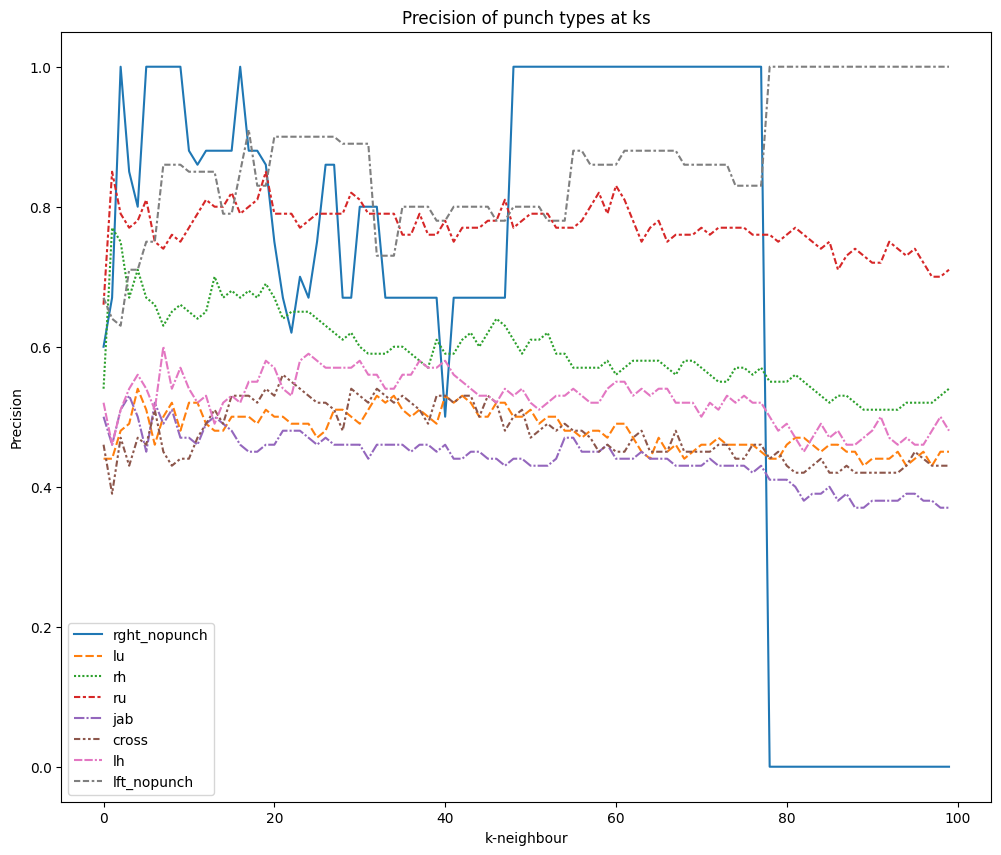

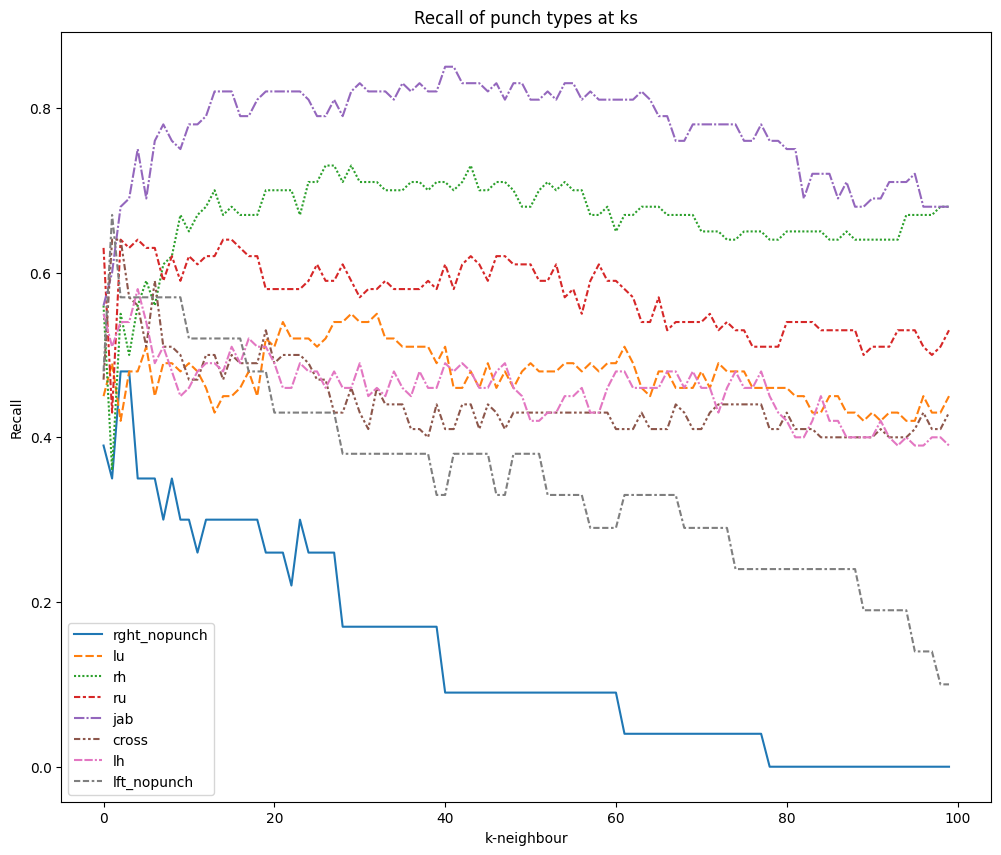

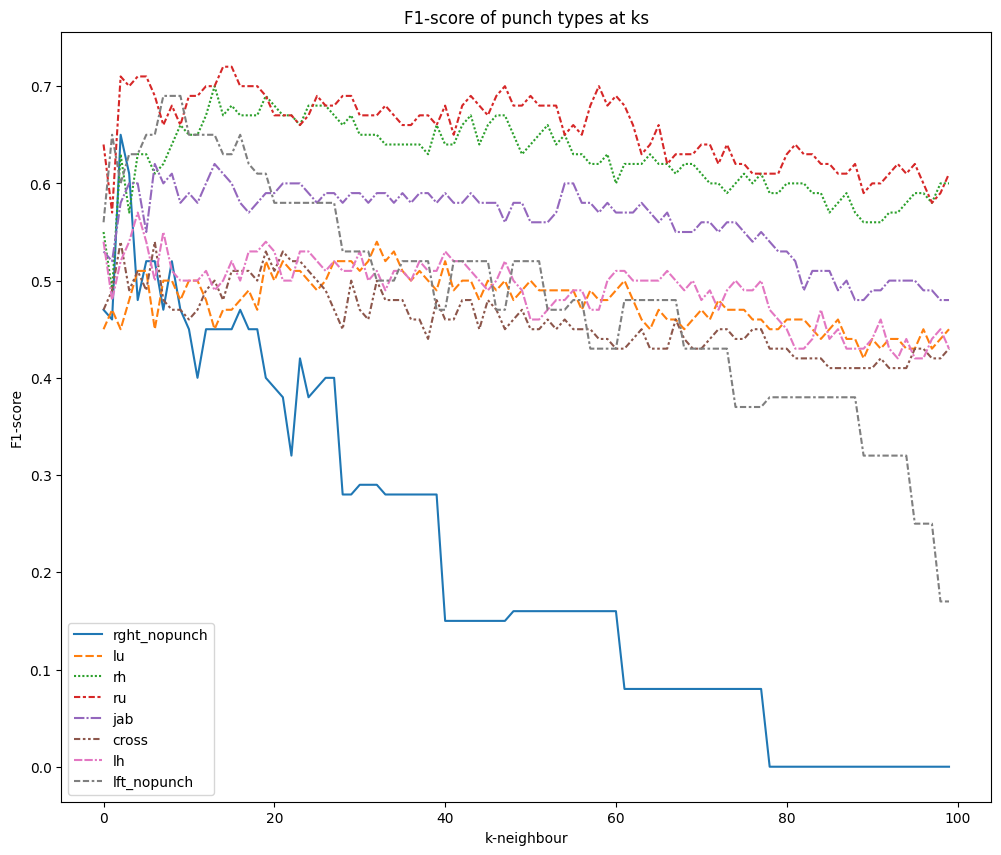

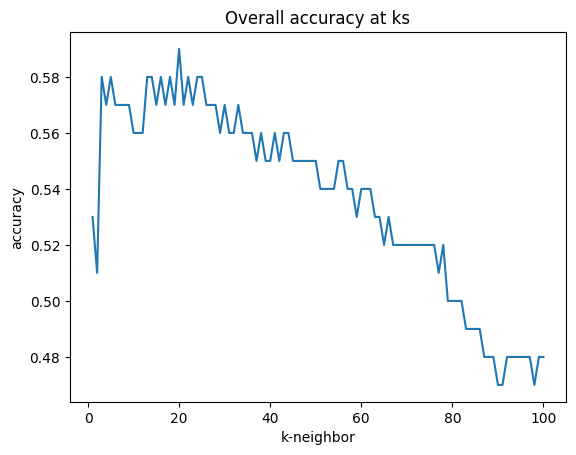

In [22]:
dict_precision_at_ks = pd.DataFrame(dict_precision_at_ks)
dict_recall_at_ks = pd.DataFrame(dict_recall_at_ks)
dict_f1_at_ks = pd.DataFrame(dict_f1_at_ks)

plot_metrics_at_ks("Precision", dict_precision_at_ks, savefig=True)
plot_metrics_at_ks("Recall", dict_recall_at_ks, savefig=True)
plot_metrics_at_ks("F1-score", dict_f1_at_ks, savefig=True)
plot_metrics_at_ks("Accuracy", accuracy_at_ks, savefig=True)